# **Uncovering Customer Feedback Insights Using NLP: Topic Modelling for a Fitness Business**


In [ ]:
### 🌟 Explore the Notebook on Colab

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/16C5gQ8EQ-WatLA8AnXm63QbVwkJv6xTy?usp=sharing)

# 1. EDA and Data Prepossessing

# 1.1 Conducting Initial Data Investigation and Data Prepossessing

In [ ]:
# Remove rows with missing values in the Comment column (Google review)
google_df = google_df.dropna(subset=['Comment'])



---


* There are no missing values in Trustpilot's Review Content column, so no rows need to be removed from the Trustpilot dataset


---




In [ ]:
# Drop columns that are not useful in Google dataset
google_df = google_df.drop(columns=['Customer Name', 'SurveyID for external use (e.g. tech support)', 'Social Media Source'])

# Drop columns that are not useful in Trustpilot dataset
trustpilot_df = trustpilot_df.drop(columns=['Review ID', 'Review Consumer User ID', 'Source Of Review', 'Domain URL', 'Webshop Name', 'Business Unit ID', 'Tags','Location ID'])

In [ ]:
# Find the number of common locations between the Google dataset and Trustpilot dataset.

# Get the unique values from the "Club's Name" column in Google dataset
unique_clubs = len(google_df["Club's Name"].unique())

# Get the total number of unique locations in Trustpilot Dataset
total_unique_locations = len(trustpilot_df['Location Name'].unique())

# Print the results
print(f"Number of unique clubs in Google review: {unique_clubs}")
print("Number of unique locations in Trustpilot review:", total_unique_locations)

Number of unique clubs in Google review: 512
Number of unique locations in Trustpilot review: 377


In [ ]:
# Get unique locations from each dataset
# Define unique locations from each dataset
google_locations = set(google_df["Club's Name"].unique())  # Define google_locations
trustpilot_locations = set(trustpilot_df["Location Name"].unique())  # Define trustpilot_locations

# Find common locations
common_locations = google_locations.intersection(trustpilot_locations)

# Get the number of common locations
num_common_locations = len(common_locations)

# Print the result
print(f"Number of common locations: {num_common_locations}")

Number of common locations: 310


In [ ]:
# Get the total number of unique review languages in Trustpilot Dataset
total_unique_languages = len(trustpilot_df['Review Language'].unique())
print("Total number of unique review languages:", total_unique_languages)

language_counts = trustpilot_df['Review Language'].value_counts()
print("\nUnique Value Counts for Review Language:\n", language_counts)

Total number of unique review languages: 20

Unique Value Counts for Review Language:
 Review Language
en     16581
da        34
pl         9
pt         9
es         9
ro         6
it         6
fr         4
de         4
et         1
uk         1
ru         1
lt         1
sv         1
sco        1
st         1
sk         1
ar         1
bg         1
tr         1
Name: count, dtype: int64




---


> Since English is the predominant language, other languages add very little value to the analysis. Therefore, rows in other languages will be dropped.


---



In [ ]:
# Drop rows in trustpilot_df that are not in English (i.e., 'en'):
trustpilot_df = trustpilot_df[trustpilot_df['Review Language'] == 'en']

In [ ]:
import pandas as pd
import nltk
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from nltk.probability import FreqDist
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import umap
import hdbscan

In [ ]:
# Perform preprocessing of the data – change to lower case, remove stopwords using NLTK, and remove numbers.
# Tokenise the data using word_tokenize from NLTK.
# Download required NLTK data
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('punkt_tab')


# Define stopwords
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    if pd.isnull(text):
        return ""

    text = text.lower()  # Convert to lowercase
    text = text.replace("’", "'")  # Normalise different apostrophe types:convert curly apostrophe to straight
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenisation
    tokens = [word for word in tokens if word not in stop_words and word != "'"]  # Remove stopwords & isolated apostrophes
    return " ".join(tokens)

# Apply updated preprocessing
google_df["cleaned_review"] = google_df["Comment"].apply(preprocess_text)
trustpilot_df["cleaned_review"] = trustpilot_df["Review Content"].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Frequency Distribution & Visualisation
# Tokenize the cleaned text (after removing words)
google_words = word_tokenize(" ".join(google_df["cleaned_review"]))
trustpilot_words = word_tokenize(" ".join(trustpilot_df["cleaned_review"]))

# Compute frequency distribution
google_freq = FreqDist(google_words)
trustpilot_freq = FreqDist(trustpilot_words)

# Get the top 10 most common words
google_common_words = google_freq.most_common(10)
trustpilot_common_words = trustpilot_freq.most_common(10)

# Convert to DataFrame for visualization
google_word_df = pd.DataFrame(google_common_words, columns=["Word", "Count"])
trustpilot_word_df = pd.DataFrame(trustpilot_common_words, columns=["Word", "Count"])

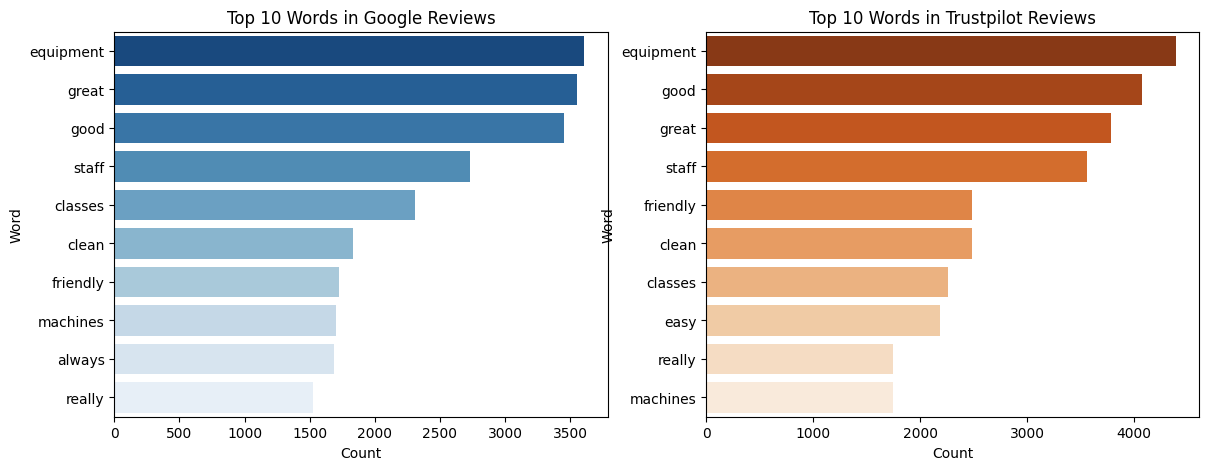

In [ ]:
# Plot bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x="Count", y="Word", data=google_word_df, ax=axes[0], hue="Word", palette="Blues_r", dodge=False, legend=False)  # Updated
axes[0].set_title("Top 10 Words in Google Reviews")

sns.barplot(x="Count", y="Word", data=trustpilot_word_df, ax=axes[1], hue="Word", palette="Oranges_r", dodge=False, legend=False)  # Updated
axes[1].set_title("Top 10 Words in Trustpilot Reviews")

plt.show()

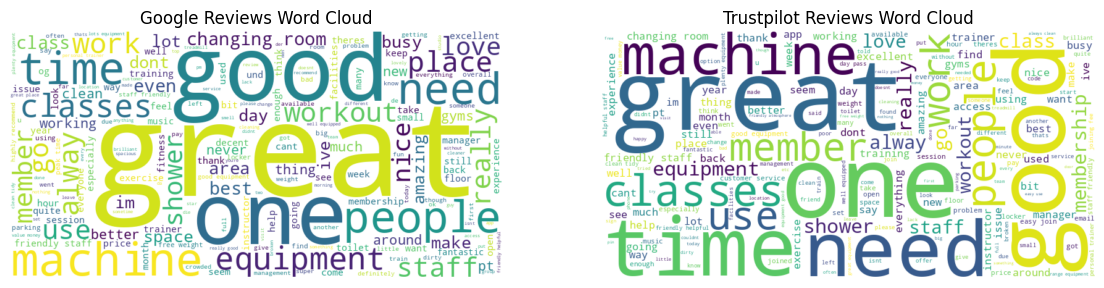

In [ ]:
# Use the wordcloud library on the cleaned data and plot the word cloud.
# Generate word clouds
google_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(google_words))
trustpilot_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(trustpilot_words))

# Plot word clouds
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(google_wordcloud, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Google Reviews Word Cloud")

axes[1].imshow(trustpilot_wordcloud, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Trustpilot Reviews Word Cloud")

plt.show()


In [ ]:
# Filter negative reviews
negative_google_df = google_df[google_df["Overall Score"] < 3].copy()
negative_trustpilot_df = trustpilot_df[trustpilot_df["Review Stars"] < 3].copy()

# Display counts of negative reviews
print(f"Negative Google reviews: {len(negative_google_df)}")
print(f"Negative Trustpilot reviews: {len(negative_trustpilot_df)}")

Negative Google reviews: 2785
Negative Trustpilot reviews: 3508


In [ ]:
from IPython.display import display, HTML

# Calculate total reviews for each dataset
total_google_reviews = len(google_df)
total_trustpilot_reviews = len(trustpilot_df)

# Calculate number of negative reviews for each dataset
num_negative_google = len(negative_google_df)
num_negative_trustpilot = len(negative_trustpilot_df)

# Calculate proportion of negative reviews for each dataset
proportion_negative_google = num_negative_google / total_google_reviews
proportion_negative_trustpilot = num_negative_trustpilot / total_trustpilot_reviews

# Create a DataFrame for the table
data = {
    'Dataset': ['Google', 'Trustpilot', 'Total'],
    'Total Reviews': [total_google_reviews, total_trustpilot_reviews, total_google_reviews + total_trustpilot_reviews],
    'Negative Reviews': [num_negative_google, num_negative_trustpilot, num_negative_google + num_negative_trustpilot],
    'Proportion of Negative Reviews': [f'{proportion_negative_google:.2%}', f'{proportion_negative_trustpilot:.2%}', '']
}
summary_table = pd.DataFrame(data)

# Calculate and format the total proportion
total_proportion = (num_negative_google + num_negative_trustpilot) / (total_google_reviews + total_trustpilot_reviews)
summary_table.loc[summary_table['Dataset'] == 'Total', 'Proportion of Negative Reviews'] = f'{total_proportion:.2%}'

# Create HTML with caption and table
html = f"""
<h3>Summary Stats of Reviews</h3>
{summary_table.to_html(index=False)}
"""

# Display HTML
display(HTML(html))

Dataset,Total Reviews,Negative Reviews,Proportion of Negative Reviews
Google,13898,2785,20.04%
Trustpilot,16581,3508,21.16%
Total,30479,6293,20.65%


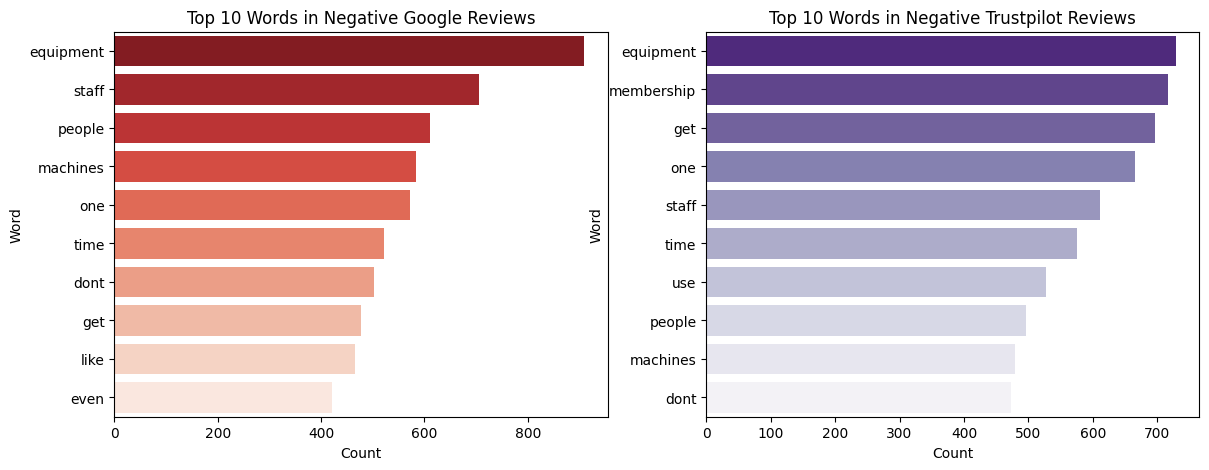

In [ ]:
# Repeat Frequency Distribution & Word Cloud for Negative Reviews
# Tokenize negative reviews
google_negative_words = word_tokenize(" ".join(google_df[google_df["Overall Score"] < 3]["cleaned_review"]))
trustpilot_negative_words = word_tokenize(" ".join(trustpilot_df[trustpilot_df["Review Stars"] < 3]["cleaned_review"]))

# Compute frequency distribution
google_negative_freq = FreqDist(google_negative_words)
trustpilot_negative_freq = FreqDist(trustpilot_negative_words)

# Get the top 10 most common words
google_negative_common_words = google_negative_freq.most_common(10)
trustpilot_negative_common_words = trustpilot_negative_freq.most_common(10)

# Convert to DataFrame for visualisation
google_negative_word_df = pd.DataFrame(google_negative_common_words, columns=["Word", "Count"])
trustpilot_negative_word_df = pd.DataFrame(trustpilot_negative_common_words, columns=["Word", "Count"])

# Plot bar charts for negative reviews
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x="Count", y="Word", data=google_negative_word_df, ax=axes[0], hue="Word", palette="Reds_r", dodge=False, legend=False)
axes[0].set_title("Top 10 Words in Negative Google Reviews")

sns.barplot(x="Count", y="Word", data=trustpilot_negative_word_df, ax=axes[1], hue="Word", palette="Purples_r", dodge=False, legend=False)
axes[1].set_title("Top 10 Words in Negative Trustpilot Reviews")

plt.show()


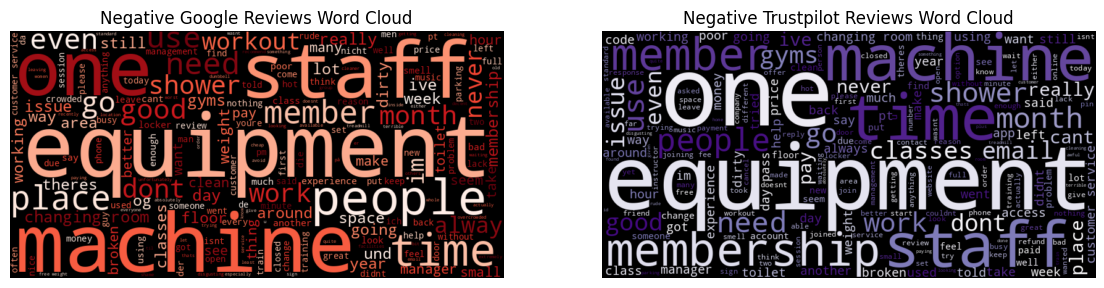

In [ ]:
# Generate word clouds for negative reviews
google_negative_wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(" ".join(google_negative_words))
trustpilot_negative_wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Purples").generate(" ".join(trustpilot_negative_words))

# Plot word clouds
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(google_negative_wordcloud, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Negative Google Reviews Word Cloud")

axes[1].imshow(trustpilot_negative_wordcloud, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Negative Trustpilot Reviews Word Cloud")

plt.show()


# 1.2 Conducting Initial Topic Modelling

In [ ]:
# Filter negative reviews based on the overall score for Google
google_negative_df = google_df[google_df["Overall Score"] < 3].copy()
google_negative_df["cleaned_text"] = google_negative_df["Comment"].apply(preprocess_text)

# Filter negative reviews based on the stars for Trustpilot
trustpilot_negative_df = trustpilot_df[trustpilot_df["Review Stars"] < 3].copy()
trustpilot_negative_df["cleaned_text"] = trustpilot_negative_df["Review Content"].apply(preprocess_text)

# Identify common locations
common_locations = google_locations.intersection(trustpilot_locations)

# Filter negative Google reviews from common locations
filtered_google_negative_df = google_negative_df[google_negative_df["Club's Name"].isin(common_locations)]

# Filter negative Trustpilot reviews from common locations
filtered_trustpilot_negative_df = trustpilot_negative_df[trustpilot_negative_df["Location Name"].isin(common_locations)]

# Merge the filtered negative reviews
merged_reviews = pd.concat([filtered_google_negative_df["cleaned_review"], filtered_trustpilot_negative_df["cleaned_review"]], ignore_index=True)

print(f"Total Merged Negative Reviews (from common locations): {len(merged_reviews)}")

Total Merged Negative Reviews (from common locations): 3947


In [ ]:
# Verify the results
# Before filtering
print(f"Total Google Negative Reviews: {len(google_negative_df)}")
print(f"Total Trustpilot Negative Reviews: {len(trustpilot_negative_df)}")

# After filtering (Keeping only reviews from common locations)
print(f"Google Negative Reviews from Common Locations: {len(filtered_google_negative_df)}") # Changed to filtered_google_negative_df
print(f"Trustpilot Negative Reviews from Common Locations: {len(filtered_trustpilot_negative_df)}") # Changed to filtered_trustpilot_negative_df

# Merged total count
print(f"Total Merged Negative Reviews: {len(merged_reviews)}")


Total Google Negative Reviews: 2785
Total Trustpilot Negative Reviews: 3508
Google Negative Reviews from Common Locations: 2098
Trustpilot Negative Reviews from Common Locations: 1849
Total Merged Negative Reviews: 3947


In [ ]:
# Preprocess the dataset - to detect any non English language to clean the dataset

from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

merged_reviews = pd.concat([google_negative_df["cleaned_review"], trustpilot_negative_df["cleaned_review"]], ignore_index=True)
merged_reviews = pd.DataFrame(merged_reviews, columns=['cleaned_review'])

merged_reviews['review_language'] = merged_reviews['cleaned_review'].apply(detect_language)

print(merged_reviews['review_language'].value_counts())

review_language
en         5512
da          161
de          132
fr          116
nl           71
af           57
no           35
ca           33
it           23
cy           23
es           17
tl           16
so           13
ro           13
pl           10
et            8
fi            7
unknown       7
pt            6
sv            6
sq            4
sw            4
id            4
hu            3
hr            2
lt            2
sk            2
sl            2
ru            1
ko            1
tr            1
lv            1
Name: count, dtype: int64




---


> Since the Trustpilot dataset does not have a language
column, some non-English reviews are included, likely from non-UK locations due to the gym operator's global presence. This step filters them out to ensure the interpretability of reviews and reduce unnecessary noise.


---



In [ ]:
# Filter out non-English reviews (keep only English reviews)
merged_reviews_cleaned = merged_reviews[merged_reviews['review_language'] == 'en']

# Check if any non-English reviews remain
display(f"Total English Reviews: {len(merged_reviews_cleaned)}")
display(f"Total Non-English Reviews Removed: {len(merged_reviews) - len(merged_reviews_cleaned)}")

'Total English Reviews: 5512'

'Total Non-English Reviews Removed: 781'

In [ ]:
# Topic Modeling with BERTopic
# Initialise UMAP for dimensionality reduction
umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Initialise BERTopic model
topic_model = BERTopic(umap_model=umap_model, language="english")

# Fit the model to the preprocessed review text from the correct column
topics, probs = topic_model.fit_transform(merged_reviews_cleaned['cleaned_review'])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# List out the topics and their frequencies
topic_freq = topic_model.get_topic_freq()

# List the top 10 topics
print(topic_freq.head(10))

# For the top 2 topics, display the most frequent words
top_2_topics = [topic_model.get_topic(i) for i in [0, 1]]
for i, topic in enumerate(top_2_topics):
    print(f"Top words for topic {i}: {topic}")

    Topic  Count
0      -1   2496
1       0    242
39      1    219
4       2    208
16      3    136
3       4    124
22      5    108
12      6     81
9       7     80
8       8     80
Top words for topic 0: [('air', np.float64(0.05614041504345546)), ('conditioning', np.float64(0.035321075235674605)), ('hot', np.float64(0.030616886568334615)), ('ac', np.float64(0.0248920107241493)), ('aircon', np.float64(0.023558400722324156)), ('con', np.float64(0.02211817496678589)), ('summer', np.float64(0.020484908418073)), ('heat', np.float64(0.02021307887080251)), ('temperature', np.float64(0.018499829939427934)), ('working', np.float64(0.016023581076216556))]
Top words for topic 1: [('fee', np.float64(0.0838606737399232)), ('joining', np.float64(0.08194243451572686)), ('discount', np.float64(0.04549950663188847)), ('code', np.float64(0.03738681058974942)), ('charged', np.float64(0.030184434261720624)), ('month', np.float64(0.027288600742546066)), ('membership', np.float64(0.021055623129406974)



---


**Top Two Topics Summary**

* Topic 0 is about air conditioning issues at the gym. Keywords like "air," "conditioning," "hot," "ac," "aircon," "summer," "heat," and "temperature" suggest that members are discussing problems with the gym being too hot or the AC not working properly.

* Topic 1 focuses on fitness classes and booking issues. Words like "class," "classes," "booked," "instructors," "cancelled," "booking," and "spin" indicate discussions about gym classes, difficulties with booking, instructor-related issues, and possibly class cancellations.


---



In [ ]:
# Barchart of the Topics displaying the top 5 words in each topic.
topic_model.visualize_barchart(top_n_topics=11)

In [ ]:
# Display the heatmap for topic similarity
topic_model.visualize_heatmap()

# 1.3 Performing Further Data Investigation - Negative Reviews in Common Locations

In [ ]:
# List out the top 20 locations with the highest number of negative reviews.
# Group negative reviews by location (Google)
google_negative_counts = negative_google_df.groupby("Club's Name")['Comment'].count().sort_values(ascending=False)

# Display top 20 locations with most negative reviews for Google
top_20_google_locations = google_negative_counts.head(20)
display(top_20_google_locations)


In [ ]:
# Group negative reviews by location (Trustpilot)
trustpilot_negative_counts = negative_trustpilot_df.groupby('Location Name')['Review Content'].count().sort_values(ascending=False)

# Display top 20 locations with most negative reviews for Trustpilot
top_20_trustpilot_locations = trustpilot_negative_counts.head(20)
display(top_20_trustpilot_locations)



---


> * While some locations appear frequently in negative reviews across both platforms, the overlap is not exact.


---



In [ ]:
# Merge the 2 datasets using Location Name and Club's Name.
# Rename columns for consistency
negative_google_df = negative_google_df.rename(columns={"Club's Name": "Location"})
negative_trustpilot_df = negative_trustpilot_df.rename(columns={"Location Name": "Location"})

# Group and count negative reviews by location for each dataset
google_counts = negative_google_df.groupby("Location")["Comment"].count().reset_index()
trustpilot_counts = negative_trustpilot_df.groupby("Location")["Review Content"].count().reset_index()

# Merge the two datasets on "Location"
merged_counts = pd.merge(google_counts, trustpilot_counts, on="Location", how="outer")

# Rename columns for clarity
merged_counts = merged_counts.rename(columns={"Comment": "Google Reviews", "Review Content": "Trustpilot Reviews"})

# Fill NaN values with 0
merged_counts = merged_counts.fillna(0)

# Calculate total reviews and sort
merged_counts["Total Reviews"] = merged_counts["Google Reviews"] + merged_counts["Trustpilot Reviews"]
merged_counts = merged_counts.sort_values(by="Total Reviews", ascending=False)

# Calculate total merged negative reviews
total_merged_negative_reviews = merged_counts["Total Reviews"].sum()

# Create the new column
merged_counts['Percentage of Total Merged Negative Reviews'] = (merged_counts['Total Reviews'] / total_merged_negative_reviews) * 100

# Format the percentage column directly in merged_counts
merged_counts['Percentage of Total Merged Negative Reviews'] = merged_counts['Percentage of Total Merged Negative Reviews'].map('{:.2f}%'.format)




---


> * The reviews are relatively sparse, with no single location dominating the number of negative reviews. For instance, the most frequently mentioned location, has only 81 reviews out of the total merged counts — accounting for just under 2% of the total. However, a noticeable trend is that the majority of the top 30 locations are in London.


---



In [ ]:
# Get top 30 locations from merged_counts directly
top_30_locations = merged_counts.head(30)['Location'].tolist()

# Filter and combine reviews for top 30
combined_reviews_top_30 = pd.concat([
negative_google_df[negative_google_df['Location'].isin(top_30_locations)]['cleaned_review'],
negative_trustpilot_df[negative_trustpilot_df['Location'].isin(top_30_locations)]['cleaned_review']
], ignore_index=True).rename('Review Text')

combined_reviews_top_30 = combined_reviews_top_30.to_frame() # convert to a dataframe

In [ ]:
# Verify the number of reviews remaining
num_reviews_top30 = len(combined_reviews_top_30)
print(f"Number of reviews remaining for top 30 locations: {num_reviews_top30}")

Number of reviews remaining for top 30 locations: 980


Word Frequency for Top 30 Locations:
[('equipment', 282), ('staff', 244), ('people', 236), ('one', 214), ('machines', 209), ('get', 202), ('dont', 201), ('time', 199), ('like', 169), ('even', 166)]


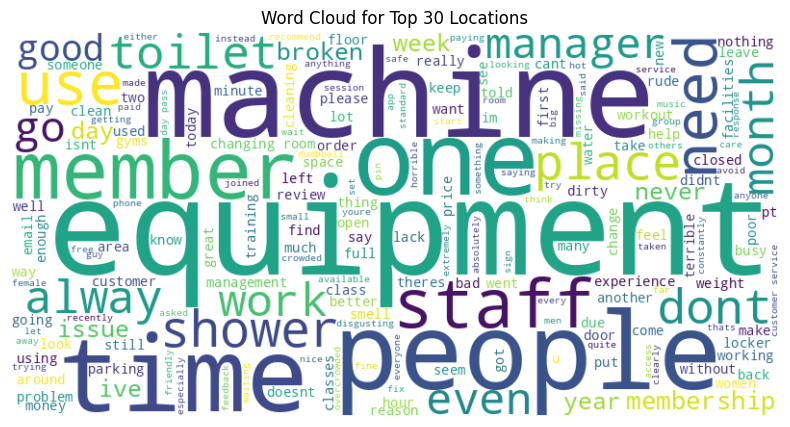

In [ ]:
# Combined_reviews_top_30['Review Text'] contains cleaned and tokenized reviews
all_words = [word for review_text in combined_reviews_top_30['Review Text'] for word in review_text.split()]

# Get the most common words
word_counts_top30 = Counter(all_words).most_common(10)

# Display the top 30 most frequent words
print("Word Frequency for Top 30 Locations:")
print(word_counts_top30)

# Generate word cloud
wordcloud_top30 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_top30, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Top 30 Locations")
plt.show()

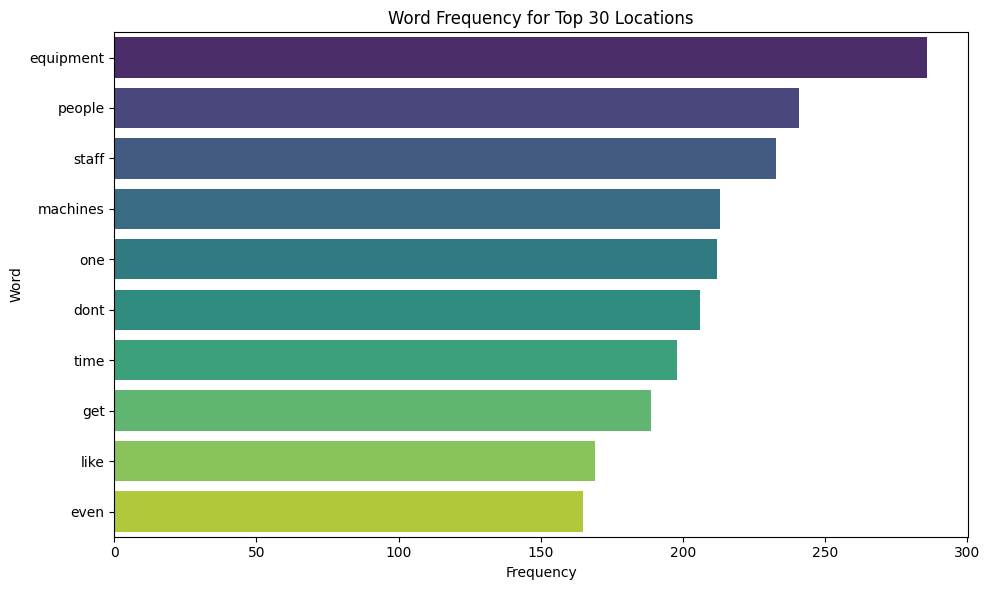

In [ ]:
# Word Frequency Data for Top 30 Locations
word_freq_data = [('equipment', 286), ('people', 241), ('staff', 233),
                  ('machines', 213), ('one', 212), ('dont', 206),
                  ('time', 198), ('get', 189), ('like', 169),
                  ('even', 165)]

# Create a DataFrame
word_freq_df = pd.DataFrame(word_freq_data, columns=['Word', 'Frequency'])

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette='viridis')
plt.title('Word Frequency for Top 30 Locations')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()



---


> * The most frequently used words in the top 30 common locations are nearly identical to those found in the full dataset of over 6,000 negative reviews across all locations. Every one of the top 10 most frequent words from the smaller dataset of 980 reviews also appears in the larger dataset. This consistency suggests that the themes of negative reviews remain largely unchanged, even when analysing a much smaller subset, reinforcing the overall trend in the data.


---



In [ ]:
# Topic Modeling with BERTopic
# Initialise UMAP for dimensionality reduction
umap_model = umap.UMAP(n_neighbors=6, n_components=2, min_dist=0.0, metric='cosine')

# Initialise BERTopic model with adjusted parameters
topic_model_top30 = BERTopic(umap_model=umap_model, language="english",
                             nr_topics=11,
                             min_topic_size=5)

# Fit the model
topics_top30, probs_top30 = topic_model_top30.fit_transform(combined_reviews_top_30['Review Text'])

In [ ]:
# List out the topics and their frequencies for top 30 locations model
topic_freq_top30 = topic_model_top30.get_topic_freq()

# List the top 10 topics
print(topic_freq_top30.head(10))

# For the top 2 topics, display the most frequent words
top_2_topics_top30 = [topic_model_top30.get_topic(i) for i in [0, 1]]  # Use topic_model_top30
for i, topic in enumerate(top_2_topics_top30):
    print(f"Top words for topic {i}: {topic}")



   Topic  Count
1      0    318
3     -1    243
2      1    158
7      2     64
5      3     50
0      4     40
6      5     40
8      6     36
4      7     13
9      8      9
Top words for topic 0: [('people', np.float64(0.02352104040904701)), ('staff', np.float64(0.021960723692805387)), ('equipment', np.float64(0.021230763425281178)), ('dont', np.float64(0.019650623065880488)), ('one', np.float64(0.019075667404319083)), ('machines', np.float64(0.01841349015152022)), ('like', np.float64(0.017906671653174895)), ('also', np.float64(0.016239545484523502)), ('manager', np.float64(0.016186385488412232)), ('get', np.float64(0.016067460753101434))]
Top words for topic 1: [('showers', np.float64(0.05527162367996341)), ('shower', np.float64(0.04742950343914014)), ('cleaning', np.float64(0.04073741641476288)), ('dirty', np.float64(0.040029523003667605)), ('water', np.float64(0.0391854474384602)), ('smell', np.float64(0.03311874851744286)), ('toilets', np.float64(0.028616548308011303)), ('changi

In [ ]:
# Visualise the topics in an interactive plot
topic_model_top30.visualize_topics()

In [ ]:
# Barchart of the Topics displaying the top 5 words in each topic.
topic_model_top30.visualize_barchart(top_n_topics=10) #make sure you're using the same variable name!

In [ ]:
# Display the heatmap for topic similarity
topic_model_top30.visualize_heatmap()



---


> * Despite the significantly smaller sample size of 980 reviews, the negative review themes and topics are more or less the same. Similar patterns in both datasets are observed in the BERTopic results, with issues including air conditioning & ventilation problems, hygiene & cleanliness issues, parking & fines, crowding & overuse of equipment, customer service & staff behavior, and passcode & entry problems.

> * Additional insights emerged, showing a more laser-focused concern on broken equipment. While the full negative dataset mentions equipment in general, the 980 reviews specifically highlight terms like “broken,” “missing,” and “attachments,” indicating more specific complaints about broken gym machines and missing parts.

> * There is also more emphasis on membership cancellations in the 980-review dataset, which shifts focus from general fees to struggles with cancellations, reflected in terms like “cancel,” “refund,” “charged,” and “emails.”

> * The issue of overcrowding is described more strongly in the 980 reviews, using explicit terms like “overcrowded” and “overcrowding,” rather than just “busy,” which highlights that overcrowding is a more pressing concern locally compared to the broader dataset.


---



# 2. Conducting Emotion Analysis on Negative Reviews

In [ ]:
from transformers import pipeline

# Load the emotion classification model - the BERT model bhadresh-savani/bert-base-uncased-emotion from Hugging Face
emotion_classifier = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion", top_k=None, truncation=True)

# Example sentence
example_text = "The gym keeps charging me even after I canceled my membership. This is unacceptable!"

# Run the emotion classifier
emotions = emotion_classifier(example_text)

# Display results
for emotion in emotions[0]:
    print(f"{emotion['label']}: {emotion['score']:.4f}")

anger: 0.9878
sadness: 0.0090
joy: 0.0014
fear: 0.0011
surprise: 0.0004
love: 0.0004


In [ ]:
# Run this model on the top 30 common locations with the highest total reviews in the merged dataset, and capture the top emotion for each review.
# Define a function to get the top emotion for each review
def get_top_emotion(review_text):
    try:
        emotions = emotion_classifier(review_text)
        return emotions[0][0]['label']  # Get the label of the highest-scoring emotion
    except:
        return "unknown"  # Handle any errors (e.g., empty reviews)

# Apply emotion detection to combined_reviews_top_30
combined_reviews_top_30['Top Emotion'] = combined_reviews_top_30['Review Text'].astype(str).apply(get_top_emotion)

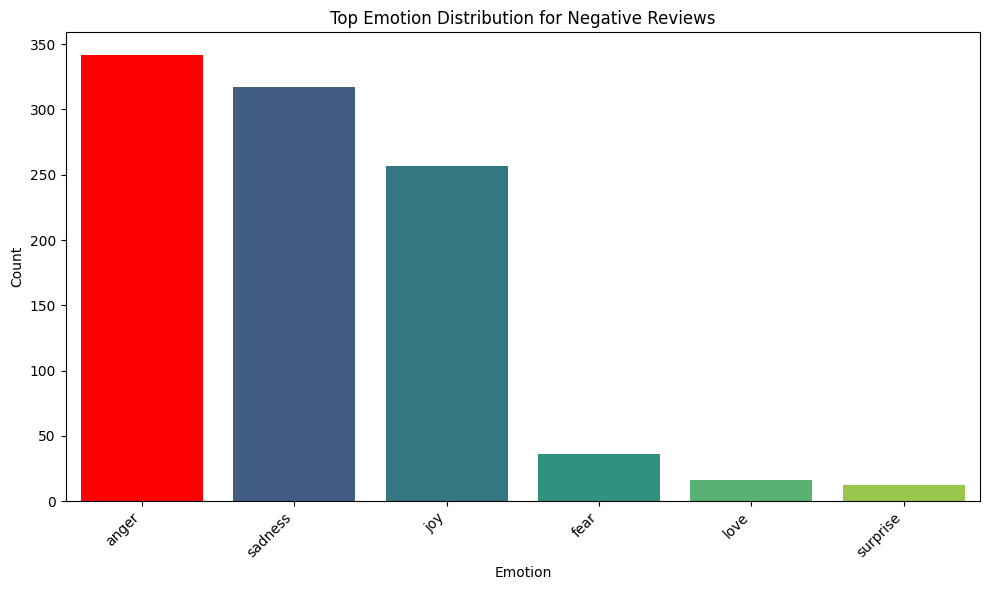

In [ ]:
# Count emotion occurrences - bhadresh-savani/bert-base-uncased-emotion
emotion_counts = combined_reviews_top_30["Top Emotion"].value_counts()

# Create bar plot using Seaborn for better aesthetics
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")

# Get the index of the "anger" emotion
anger_index = emotion_counts.index.get_loc('anger')

# Change the color of the "anger" bar to red
ax.patches[anger_index].set_facecolor('red')

plt.title("Top Emotion Distribution for Negative Reviews")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
# Inspect reviews classified as "sadness"
misclassified_joy = combined_reviews_top_30[combined_reviews_top_30['Top Emotion'] == 'sadness']

pd.set_option('display.max_colwidth', None)  # Show full text in Pandas output
display(combined_reviews_top_30[combined_reviews_top_30['Top Emotion'] == 'sadness'][['Review Text', 'Top Emotion']].head(3))

,Review Text,Top Emotion
2,staff allowed blame annoying people hoxton get second time working guy clear brown hair work start blame dressing heavy metal shirt singer band criminal past thats employee blaming wonder guy make circus hip hop rock shirt go amy winehouse shirt would like staff bother telling drug addicted whats point suggest better choose page wages guy ruined mood work today,sadness
6,u dont wan na get fit place go poorly equipped lockers whole,sadness
7,dumbbells shelves dusty dirty one pays attention also soap ever toilets ac working properly smells bad,sadness


In [ ]:
# Inspect reviews classified as "joy"
misclassified_joy = combined_reviews_top_30[combined_reviews_top_30['Top Emotion'] == 'joy']

pd.set_option('display.max_colwidth', None)  # Show full text in Pandas output
display(combined_reviews_top_30[combined_reviews_top_30['Top Emotion'] == 'joy'][['Review Text', 'Top Emotion']].head(3))

,Review Text,Top Emotion
4,overcrowded full teenagers look plus would really benefit bit cleaning,joy
13,nice always crowded cant go want specific times slots otherwise exercising becomes pain machines never free classes small studio theyre alway full buy upper floor extend would space machines available people im even sure safe legal people small space case fire emergency wouldnt easy evacuate everyone,joy
17,dear influencers stop using kit store set filming equipment dont cheap buy camera tripod something realize people need use equipment filming training sessions,joy




---


> * The BERT model bhadresh-savani/bert-base-uncased-emotion oddly classified some negative reviews as joy and sadness. Upon inspection, many of these reviews appeared to skew more towards anger rather than sadness or joy. This suggests that the model’s understanding of context is not ideal, and there is significant room for improvement and fine-tuning to better capture emotions in negative reviews, particularly for more context-specific emotions like anger.

> * It has been decided to run a fine-tuned DeBERTa-based emotion classifier to assess whether the results improve. Given the limitations observed with the bhadresh-savani/bert-base-uncased-emotion model, particularly in classifying negative reviews as joy or sadness rather than anger,  it is expected that the DeBERTa-based model will provide better accuracy in capturing emotions, particularly for context-sensitive emotions like anger.


---




In [ ]:
# Load the fine-tuned DeBERTa-based emotion classifier - AnkitAI/deberta-v3-small-base-emotions
emotion_classifier = pipeline("text-classification", model="AnkitAI/deberta-v3-small-base-emotions-classifier")

# Define a function to get the top emotion
def get_top_emotion(review_text):
    try:
        emotions = emotion_classifier(review_text)
        return emotions[0]['label']  # Get the label of the highest-scoring emotion
    except Exception as e:
        print(f"Error processing review: {e}")
        return "unknown"  # Handle any errors

# Apply emotion detection to your dataset
combined_reviews_top_30['Top Emotion'] = combined_reviews_top_30['Review Text'].astype(str).apply(get_top_emotion)

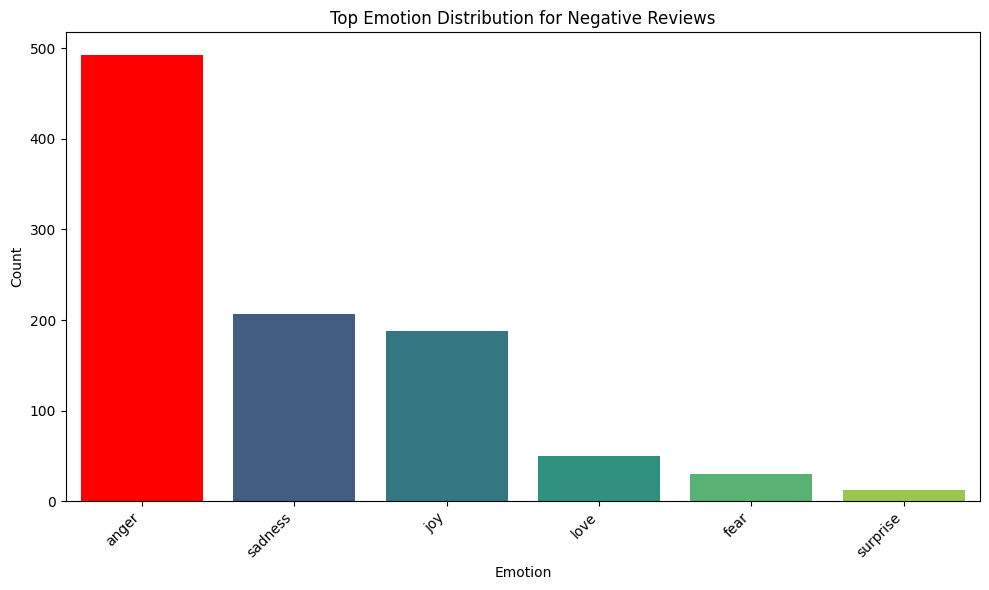

In [ ]:
# Count emotion occurrences - AnkitAI
emotion_counts = combined_reviews_top_30["Top Emotion"].value_counts()

# Create bar plot using Seaborn for better aesthetics
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")

# Get the index of the "anger" emotion
anger_index = emotion_counts.index.get_loc('anger')

# Change the color of the "anger" bar to red
ax.patches[anger_index].set_facecolor('red')

plt.title("Top Emotion Distribution for Negative Reviews")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



---


> * Improvements in accuracy have been observed with the AnkitAI/deberta-v3 model, particularly in the shift from misclassifying reviews as sadness or joy to more accurate classifications, such as anger. While some misclassification still occurs, the model demonstrates sufficient performance to be considered a more suitable choice for downstream tasks to analyse angry reviews.



---





In [ ]:
# Combined_reviews_top_30 has the 'Top Emotion' column, extract all the negative reviews where anger is top emotion.
# Filter for angry reviews
angry_reviews_top30 = combined_reviews_top_30[combined_reviews_top_30['Top Emotion'] == 'anger']

# Display all angry reviews
display(angry_reviews_top30)

,Review Text,Top Emotion
1,airconditioning doesnt work,anger
2,staff allowed blame annoying people hoxton g...,anger
4,overcrowded full teenagers look plus would rea...,anger
6,dumbbells shelves dusty dirty one pays attenti...,anger
7,never,anger
...,...,...
972,showers constantly cold,anger
974,always machines brokenout use enough equipment...,anger
975,horrible overall ac ever always sweat excessiv...,anger
976,dont recommend pt jelena rude members overhea...,anger


In [ ]:
print(f"angry_reviews_top30: {len(angry_reviews_top30)}")

angry_reviews_top30: 493


In [ ]:
# Initialise BERTopic model (adjust parameters if needed)
topic_model_angry = BERTopic(language="english")

# Fit the model to the angry reviews
topics_angry, probs_angry = topic_model_angry.fit_transform(angry_reviews_top30['Review Text'])

# Get topic frequencies
topic_freq_angry = topic_model_angry.get_topic_freq()
display(topic_freq_angry.head(10))  # Display top 10 topics

,Topic,Count
2,-1,114
3,0,108
4,1,88
1,2,55
7,3,38
5,4,24
9,5,20
8,6,17
6,7,16
0,8,13


In [ ]:
# 'topic_model_angry' is the BERTopic model instance
topic_model_angry.visualize_barchart(top_n_topics=10)

In [ ]:
# Visualise the topics in an interactive plot
topic_model_angry.visualize_topics()



---


The 493 anger reviews dataset, analysed through BERT topic modeling, shares several similarities with previous datasets, including cleanliness and hygiene, broken equipment, customer service, membership & access problems, and parking & fines.


---


**Differences from Previous Runs**
* The anger-focused dataset shows a much clearer pattern of issues around broken equipment and membership access compared to previous runs where general complaints about gym conditions (e.g., cleanliness, overcrowding) were more prevalent.

* The inclusion of terms like rude, manager, and attitude in Topic 2 reflects a sharper focus on interpersonal conflicts, possibly highlighting that poor customer service or lack of professional behavior from staff can fuel more intense feelings of anger.

* The parking fines issue (Topic 4) shows a deeper concern with external logistical issues, which weren't as pronounced in the earlier dataset, suggesting a stronger influence of real-world challenges faced by gym-goers.


---


**Primary Issues Leading to Angry Reviews**
* Hygiene & Cleanliness: Persisting issues with unclean or poorly maintained showers and toilets are a central concern. These facilities are essential for a comfortable gym experience, and their neglect likely drives anger, especially when it affects personal hygiene.

* Broken Equipment & Maintenance: Faulty or poorly maintained gym equipment that disrupts workout routines is a major frustration. Members expect functioning equipment, and its absence can lead to strong dissatisfaction.

* Customer Service Issues: Staff behavior—specifically rudeness and poor attitudes—emerges as a significant source of anger. Negative interactions with staff, particularly if the issue isn't resolved satisfactorily, can escalate into anger.

* Parking Issues & Fines: Parking availability, fines, and related complications are more prominent in this dataset, suggesting that logistical barriers to accessing the gym, such as limited parking or fines, can contribute to frustration.

* Membership and Access Problems: Issues with accessing the gym, whether through app problems, membership issues, or closures, seem to be a key factor behind angry reviews. These access-related frustrations affect members' ability to use the facilities as intended, leading to negative experiences.


---





# 3. Applying a Large Language Model from Hugging Face



---


* The Phi-4 model has been fine-tuned using 4-bit quantisation to ensure computational efficiency in non-enterprise environments, while still effectively preserving its ability to capture general patterns..


---



In [ ]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import re

#  Model Name
model_name = "microsoft/Phi-4-mini-instruct"

# 4-bit Quantization Configuration
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization for speed
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=False
)

# Load Model with 4-bit quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Efficient Text Generation Pipeline
text_generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=300,  # Reduced max_length for speed
    truncation=True,
    do_sample=False  # Greedy decoding for speed
)

# Extract Top 3 Topics from LLM Output
def clean_topics_output(response_text):
    topics = re.findall(r"\d+\.\s*(.+)", response_text)
    return topics[:3] if len(topics) >= 3 else ["Incomplete", "Incomplete", "Incomplete"]

# Batch Processing for Speed
def extract_topics_batch(reviews):
    prompts = [f"In the following review, list 3 main topics:\n\n{review}" for review in reviews]
    responses = text_generator(prompts)
    return [clean_topics_output(response[0]['generated_text']) for response in responses]

# Apply Batch Processing
batch_size = 128
topic_results = []

for i in range(0, len(angry_reviews_top30), batch_size):
    batch = angry_reviews_top30["Review Text"].iloc[i:i+batch_size].tolist()
    topic_results.extend(extract_topics_batch(batch))

# Convert to DataFrame
topic_df = pd.DataFrame(topic_results, columns=['Topic 1', 'Topic 2', 'Topic 3'])
angry_reviews_top30 = pd.concat([angry_reviews_top30.reset_index(drop=True), topic_df], axis=1)




---


> While Phi-4 identifies the top 3 topics within individual reviews, it does not inherently group or cluster these topics across all reviews to uncover broader themes. In contrast, BERTopic excels at clustering similar topics together, enabling the discovery of overarching themes and how different topics relate to one another. This approach facilitates a more holistic understanding of the data, moving beyond insights derived from individual reviews.



---



In [ ]:
# Compile all topics into a comprehensive list:
# Create a list of all topics (excluding None or empty values)
all_topics = angry_reviews_top30[['Topic 1', 'Topic 2', 'Topic 3']].values.flatten()
all_topics = [topic for topic in all_topics if topic]  # Remove empty values

# Run BERTopic directly on the list of topics
topic_model = BERTopic(umap_model=umap_model, language="english", nr_topics=10)
topics, probs = topic_model.fit_transform(all_topics)

# Create a DataFrame with topics and probabilities
topic_df = pd.DataFrame({"Topic": topics, "Probability": probs})

# Display the result
display(topic_df.head())


,Topic,Probability
0,0,1.000000
1,0,1.000000
2,0,1.000000
3,0,0.661639
4,0,0.642864


In [ ]:
topic_model.visualize_barchart()



---


> * Although the top topic (Topic 0) appears incomplete in Phi-4 with its top three topics, its relatively large size of 1,071 allows BERTopic to effectively extract keywords and group related themes together.



---



In [ ]:
#  'topic_model_angry' is  BERTopic model object
for topic in topic_model_angry.get_topic_info()['Topic']:  # Iterate through topics in the model
    print(f"Top words for Topic {topic}:")
    print(topic_model_angry.get_topic(topic))  # Use topic_model_angry.get_topic()
    print("\n")

In [ ]:
topic_model.visualize_heatmap()



---


> **BERTopic Results**

* The results are broadly similar to previous runs but with a more localised focus:

* **Topic 0**: Focus on showers, cleaning, disgusting, and overall hygiene issues.

* **Topic 1**: Focus on equipment, machines, weights, and more specific mentions of broken equipment.

* **Topic 2**: Focus on membership, refunds, accounts, and emails; Issues with membership and cancellation.

* **Topic 3**: Emphasis on staff, rude, manager, and attitude, highlighting more frustration with staff and management.

* **Topic 4**: Strong focus on parking, fine, appeal, and related concerns, introducing a new theme of parking-related issues.


---


> **More detailed Insights**

* Cleaner Segmentation of Issues: The use of showers, cleaning, toilets, and disgusting in Topic 0 shows that BERTopic is now better able to extract and distinguish hygiene-related concerns, providing a clearer segmentation of user complaints.

* Equipment-Related Complaints: There is more specific mention of machines, weights, and broken in Topic 1, indicating that complaints around equipment are more focused on specific problems now compared to earlier results.

* Administrative issues are more pronounced: The appearance of terms like membership, refund, account, and email in Topic 2 shows a noticeable shift in user complaints toward administrative hurdles, such as cancellations and issues with membership services. This wasn't as evident in previous analyses.

* Parking issues highlighted: The prominence of parking and fine in Topic 4 suggests that this is a more pressing issue for users now, pointing to either an increase in complaints related to parking or a shift in the data set that now captures these complaints more effectively.


---


> **Further Insights**

* Stronger Focus on Customer Service: The clear association of rude, staff, and manager in Topic 3 further emphasises that customer service-related issues are a key factor in negative reviews.

* Possible Geographical/Regional Shift: Given the increased prominence of parking-related issues in Topic 4, it may suggest that the location of the reviews is influencing the themes (i.e., users from areas with limited parking might be raising these issues more prominently). This could be a regional difference or shift in the dataset that highlights local concerns.

* Hygiene and Cleanliness Remain Major Pain Points: While hygiene-related complaints are not new, the increased use of terms like disgusting indicates that these issues may have grown more severe or detailed in users' reviews, suggesting a possible uptick in user dissatisfaction.
---

In [ ]:
# Combine all topic columns into a single series
all_topics = pd.concat([angry_reviews_top30['Topic 1'], angry_reviews_top30['Topic 2'], angry_reviews_top30['Topic 3']])

# Get unique topics, excluding empty strings and NaN values
unique_topics = all_topics[all_topics != ""].dropna().unique()

# Print the unique topics
print("Unique Topics:")
for topic in unique_topics:
    print(topic)

In [ ]:
# Define the list of topics obtained from the negative customer reviews
topics_list = [
    "Equipment Maintenance Issues",
    "Cleanliness and Hygiene Concerns",
    "Poor Customer Service",
    "Membership Cancellation Difficulties",
    "Overcrowding and Limited Equipment Availability",
    "Unclear or Hidden Fees",
    "Temperature and Ventilation Problems",
    "Lack of Proper Gym Etiquette Enforcement",
    "Limited Class Offerings or Scheduling Issues",
    "Inadequate Personal Training Services",
    "Food Court and Snack Service Concerns",
    "Lack of Parking or Transportation Options",
    "Limited Facilities for Different Age Groups or Fitness Levels",
    "Insufficient Staff",
    "Lack of Clear Information",
    "Lack of Transparency in Membership Fees or Refund Policies",
    "Lack of Facilities for Non-Gym Activities",
    "Lack of Online Resources or Mobile App"
]

# Construct the prompt for Phi 4
prompt = f"For the following text topics obtained from negative customer reviews, can you give some actionable insights that would help this gym company?\n\n{', '.join(topics_list)}"

# Generate insights using Phi 4
response = text_generator(prompt, max_length=1000, do_sample=True)  # Generating text with a max length of 1000 tokens
insights = response[0]['generated_text']

# Display the insights (This is where the output will be shown)
print("Insights from Phi-4:")
print(insights)


Insights from Phi-4:
For the following text topics obtained from negative customer reviews, can you give some actionable insights that would help this gym company?

Equipment Maintenance Issues, Cleanliness and Hygiene Concerns, Poor Customer Service, Membership Cancellation Difficulties, Overcrowding and Limited Equipment Availability, Unclear or Hidden Fees, Temperature and Ventilation Problems, Lack of Proper Gym Etiquette Enforcement, Limited Class Offerings or Scheduling Issues, Inadequate Personal Training Services, Food Court and Snack Service Concerns, Lack of Parking or Transportation Options, Limited Facilities for Different Age Groups or Fitness Levels, Insufficient Staff, Lack of Clear Information, Lack of Transparency in Membership Fees or Refund Policies, Lack of Facilities for Non-Gym Activities, Lack of Online Resources or Mobile App


For Customer Service:

Actionable Insight 1: Staff Training - Implement a comprehensive staff training program focusing on communication

In [ ]:
# Phi 4 suggestions that the company can employ to address customer concerns.
# Display Insights in Markdown Format - for better visiblity

from IPython.core.display import display, Markdown

insights_text = """
# Insights from Phi-4

## Topics from Negative Reviews
- **Equipment Maintenance Issues**
- **Cleanliness and Hygiene Concerns**
- **Poor Customer Service**
- **Membership Cancellation Difficulties**
- **Overcrowding and Limited Equipment Availability**
- **Unclear or Hidden Fees**
- **Temperature and Ventilation Problems**
- **Lack of Proper Gym Etiquette Enforcement**
- **Limited Class Offerings or Scheduling Issues**
- **Inadequate Personal Training Services**
- **Lack of Parking or Transportation Options**
- **Limited Facilities for Different Age Groups or Fitness Levels**
- **Insufficient Staff**
- **Lack of Clear Information**
- **Lack of Transparency in Membership Fees or Refund Policies**
- **Lack of Facilities for Non-Gym Activities**
- **Lack of Online Resources or Mobile App**

## Actionable Insights

### Customer Service
- **Actionable Insight 1: Staff Training** - Implement a comprehensive staff training program focusing on communication skills, empathy, problem-solving, and conflict resolution to improve their ability to effectively handle customer interactions.
- **Actionable Insight 2: Feedback System** - Establish or enhance an existing customer feedback system to regularly gather insights into customer service experiences and identify areas for improvement.
- **Actionable Insight 3: Customer Service Policies** - Develop transparent and easily accessible customer service policies and guidelines addressing customer issues and ensuring consistent responses to customer concerns.

### Overcrowding and Limited Equipment Availability

- **Actionable Insight 1: Scheduling and Utilization** - Implement a staggered class schedule, using a booking/check-in system, to better manage gym attendance, minimize congestion, and ensure equipment availability.

- **Actionable Insight 2: Space Optimization** - Explore opportunities to expand gym facilities or rearrange existing spaces. Consider adding alternative equipment, such as bodyweight exercises, to alleviate overcrowding.

- **Actionable Insight 3: Communication and Sign-ups** - Clearly communicate gym class schedules and equipment availability through multiple channels (website, social media, newsletters). Encourage customers to sign up for classes to promote proper utilization and reduce congestion.

### Membership Cancellation Difficulties
- **Actionable Insight 1: Transparent and Straightforward Policies** - Clearly articulate membership cancellation policies, including fees and timeline requirements, in an easily accessible manner. Simplify procedures by removing unnecessary steps, if appropriate.

- **Actionable Insight 2: Customer Service Training** - Train customer service personnel to address cancellation inquiries efficiently, empathetically, and professionally. Empower them with proper decision-making authority to empower employees and avoid unnecessary delays.

- **Actionable Insight 3: Multiple Cancellation Channels** - Provide multiple channels through which members can request cancellation directly (e.g., online form, email, phone). Streamline processes internally and ensure timely responses.

## Recommendations

## Topics from Negative Reviews
- **Cleanliness and Hygiene Concerns**
- **Well-Maintained Equipment and Facilities**
- **Excellent Gym Class Offerings**
- **Friendly and Knowledgeable Staff**
- **Convenient Location and Easy Parking**
- **Excellent Customer Service**
- **Friendly Food Court and Snack Service**
- **Convenient Online Resources or Mobile App**
- **Encouraging Environment and Supportive Community**
- **Well-Staffed Gym**
- **Clear Information and Transparency**
- **No Membership Cancellation Difficulties**
- **Diverse Facilities and Classes**
- **Transparent Membership Fees and Refund Policies**

### Cleanliness and Hygiene Concerns
- **Recommendation: Adopt and Strictly Enforce a Hygienic Protocol** - Implement strict hygiene protocols aligned with health and fitness industry standards, including cleaning schedules, use of personal protective equipment, and sanitizing equipment regularly.

- **Recommendation: Publicize Hygiene Protocols** - Transparently share the hygiene protocols to assure customers that cleanliness concerns are being addressed adequately.

- **Recommendation: Signage and Reminders** - Place clear signage throughout the gym premises reminding staff and members to adhere to hygiene practices.

### Well-Maintained Equipment and Facilities
- **Recommendation: Regular Maintenance and Assessments** - Implement regular equipment maintenance schedules and conduct timely assessments to ensure safe and functional gym facilities.

- **Recommendation: Clear Communication** - Communicate the equipment maintenance schedule to gym members, highlighting that they can expect a consistently clean and well-maintained environment.

- **Recommendation: Feedback Mechanism** - Establish a clear feedback system for gym members to report equipment issues, maintenance concerns, or facility-related matters.

### Well-Staffed Gym
- **Recommendation: Evaluate Staffing Levels** - Routinely assess staffing levels in consideration of customer demand, gym schedule, and staffing needs. Ensure adequate staffing personnel as required.

- **Recommendation: Positive Staff-Member Interactions** - Encourage staff members to foster a positive and collaborative working environment, while also enhancing their customer interaction skills to promote a welcoming gym ambience.

- **Recommendation: Staff Recognition** - Consider implementing a staff recognition program that rewards staff members' hard work and dedication, boosting morale and fostering a culture of appreciation.

### Clear Information and Transparency
- **Recommendation: Transparent Information** - Provide clear and up-to-date information to gym members regarding various aspects of the gym experience, such as membership policies, class schedules, and gym amenities.

- **Recommendation: Online Resources** - Create and maintain comprehensive online resources and mobile apps, with easily accessible information relating to membership, facilities, services, schedules, and policies.

- **Recommendation: Transparent Billing and Policies** - Design clear and accessible billing policies.


"""

display(Markdown(insights_text))



# Insights from Phi-4

## Topics from Negative Reviews
- **Equipment Maintenance Issues**
- **Cleanliness and Hygiene Concerns**
- **Poor Customer Service**
- **Membership Cancellation Difficulties**
- **Overcrowding and Limited Equipment Availability**
- **Unclear or Hidden Fees**
- **Temperature and Ventilation Problems**
- **Lack of Proper Gym Etiquette Enforcement**
- **Limited Class Offerings or Scheduling Issues**
- **Inadequate Personal Training Services**
- **Lack of Parking or Transportation Options**
- **Limited Facilities for Different Age Groups or Fitness Levels**
- **Insufficient Staff**
- **Lack of Clear Information**
- **Lack of Transparency in Membership Fees or Refund Policies**
- **Lack of Facilities for Non-Gym Activities**
- **Lack of Online Resources or Mobile App**

## Actionable Insights

### Customer Service
- **Actionable Insight 1: Staff Training** - Implement a comprehensive staff training program focusing on communication skills, empathy, problem-solving, and conflict resolution to improve their ability to effectively handle customer interactions.
- **Actionable Insight 2: Feedback System** - Establish or enhance an existing customer feedback system to regularly gather insights into customer service experiences and identify areas for improvement.
- **Actionable Insight 3: Customer Service Policies** - Develop transparent and easily accessible customer service policies and guidelines addressing customer issues and ensuring consistent responses to customer concerns.

### Overcrowding and Limited Equipment Availability

- **Actionable Insight 1: Scheduling and Utilization** - Implement a staggered class schedule, using a booking/check-in system, to better manage gym attendance, minimize congestion, and ensure equipment availability.

- **Actionable Insight 2: Space Optimization** - Explore opportunities to expand gym facilities or rearrange existing spaces. Consider adding alternative equipment, such as bodyweight exercises, to alleviate overcrowding.

- **Actionable Insight 3: Communication and Sign-ups** - Clearly communicate gym class schedules and equipment availability through multiple channels (website, social media, newsletters). Encourage customers to sign up for classes to promote proper utilization and reduce congestion.

### Membership Cancellation Difficulties
- **Actionable Insight 1: Transparent and Straightforward Policies** - Clearly articulate membership cancellation policies, including fees and timeline requirements, in an easily accessible manner. Simplify procedures by removing unnecessary steps, if appropriate.

- **Actionable Insight 2: Customer Service Training** - Train customer service personnel to address cancellation inquiries efficiently, empathetically, and professionally. Empower them with proper decision-making authority to empower employees and avoid unnecessary delays.

- **Actionable Insight 3: Multiple Cancellation Channels** - Provide multiple channels through which members can request cancellation directly (e.g., online form, email, phone). Streamline processes internally and ensure timely responses.

## Recommendations 

## Topics from Negative Reviews
- **Cleanliness and Hygiene Concerns**
- **Well-Maintained Equipment and Facilities**
- **Excellent Gym Class Offerings**
- **Friendly and Knowledgeable Staff**
- **Convenient Location and Easy Parking**
- **Excellent Customer Service**
- **Friendly Food Court and Snack Service**
- **Convenient Online Resources or Mobile App**
- **Encouraging Environment and Supportive Community**
- **Well-Staffed Gym**
- **Clear Information and Transparency**
- **No Membership Cancellation Difficulties**
- **Diverse Facilities and Classes**
- **Transparent Membership Fees and Refund Policies**

### Cleanliness and Hygiene Concerns
- **Recommendation: Adopt and Strictly Enforce a Hygienic Protocol** - Implement strict hygiene protocols aligned with health and fitness industry standards, including cleaning schedules, use of personal protective equipment, and sanitizing equipment regularly.

- **Recommendation: Publicize Hygiene Protocols** - Transparently share the hygiene protocols to assure customers that cleanliness concerns are being addressed adequately.

- **Recommendation: Signage and Reminders** - Place clear signage throughout the gym premises reminding staff and members to adhere to hygiene practices.

### Well-Maintained Equipment and Facilities
- **Recommendation: Regular Maintenance and Assessments** - Implement regular equipment maintenance schedules and conduct timely assessments to ensure safe and functional gym facilities.

- **Recommendation: Clear Communication** - Communicate the equipment maintenance schedule to gym members, highlighting that they can expect a consistently clean and well-maintained environment.

- **Recommendation: Feedback Mechanism** - Establish a clear feedback system for gym members to report equipment issues, maintenance concerns, or facility-related matters.

### Well-Staffed Gym
- **Recommendation: Evaluate Staffing Levels** - Routinely assess staffing levels in consideration of customer demand, gym schedule, and staffing needs. Ensure adequate staffing personnel as required.

- **Recommendation: Positive Staff-Member Interactions** - Encourage staff members to foster a positive and collaborative working environment, while also enhancing their customer interaction skills to promote a welcoming gym ambience.

- **Recommendation: Staff Recognition** - Consider implementing a staff recognition program that rewards staff members' hard work and dedication, boosting morale and fostering a culture of appreciation.

### Clear Information and Transparency
- **Recommendation: Transparent Information** - Provide clear and up-to-date information to gym members regarding various aspects of the gym experience, such as membership policies, class schedules, and gym amenities.

- **Recommendation: Online Resources** - Create and maintain comprehensive online resources and mobile apps, with easily accessible information relating to membership, facilities, services, schedules, and policies.

- **Recommendation: Transparent Billing and Policies** - Design clear and accessible billing policies.




# 4. LDA (Gensim) for Comparative Analysis

In [ ]:
from gensim import corpora
from gensim.models import LdaModel

# Perform the necessary preprocessing for running the LDA model from Gensim.
# Use angry reviews from the top 30 locations across both datasets to maintain consistency and Cross-Validation
# Tokenize the 'review_text' column for further analysis.
tokenized_angry_reviews = angry_reviews_top30['Review Text'].apply(lambda x: x.split()).tolist()

# Create the dictionary from the tokenized angry reviews
dictionary = corpora.Dictionary(tokenized_angry_reviews)

# Convert the tokenized reviews into a bag-of-words format (Corpus)
corpus = [dictionary.doc2bow(text) for text in tokenized_angry_reviews]

# Set the number of topics for LDA
num_topics = 10

# Run LDA with 10 topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

# Display the topics
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))


Topic: 0 
Words: 0.013*"staff" + 0.010*"£" + 0.006*"another" + 0.006*"people" + 0.006*"membership" + 0.006*"members" + 0.005*"place" + 0.005*"rude" + 0.005*"reviews" + 0.005*"get"
Topic: 1 
Words: 0.015*"class" + 0.008*"member" + 0.008*"even" + 0.007*"dont" + 0.006*"staff" + 0.006*"rude" + 0.006*"cancel" + 0.006*"changing" + 0.006*"time" + 0.006*"also"
Topic: 2 
Words: 0.015*"weights" + 0.011*"people" + 0.007*"away" + 0.007*"place" + 0.007*"equipment" + 0.006*"im" + 0.006*"one" + 0.005*"manager" + 0.005*"look" + 0.005*"using"
Topic: 3 
Words: 0.010*"parking" + 0.008*"one" + 0.008*"ive" + 0.007*"get" + 0.006*"£" + 0.006*"like" + 0.006*"around" + 0.006*"time" + 0.006*"place" + 0.005*"never"
Topic: 4 
Words: 0.016*"equipment" + 0.013*"staff" + 0.008*"machines" + 0.008*"machine" + 0.008*"go" + 0.007*"member" + 0.007*"horrible" + 0.007*"showers" + 0.006*"get" + 0.006*"closed"
Topic: 5 
Words: 0.009*"one" + 0.008*"staff" + 0.007*"nie" + 0.007*"even" + 0.007*"enough" + 0.006*"people" + 0.006*



---


> Overall, the topics identified  suggest that members have significant complaints about:

> * Staff-related issues: Rude or unhelpful staff appears consistently across topics.

> * Gym equipment: Complaints about availability, quality, and maintenance of equipment, including weights and machines.

> * Facilities: Issues with the gym's environment (e.g., air quality, temperature), cleanliness (e.g., showers), and parking.

> * Membership/Fees: Complaints related to membership, cancellations, and pricing.

> * Gym management: Several topics suggest frustration with management, including poor customer service and lack of facilities or support.


---



In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

# Prepare the visualisation data using the updated function
vis_data = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Display the visualization
pyLDAvis.display(vis_data)



---


> **Model Comparison Conclusion**




* While all models—LDA, BERTopic, and Phi-4—identify common keywords such as “staff,” “equipment,” and “people,” the quality and structure of the topics they produce vary significantly.

* LDA tends to generate broad and overlapping topics, which makes it difficult to disentangle specific complaints. The boundaries between themes are often blurred, resulting in repetitive or generic groupings. This lack of clarity can hinder downstream analysis, especially when the goal is to derive targeted and actionable insights from nuanced feedback.

* In contrast, BERTopic produces more distinct and interpretable themes. It excels at isolating specific concerns—such as cleanliness, staff behavior, or resource availability—with minimal overlap between topics. This clarity enhances the interpretability and practical value of the results, especially in applications where thematic separation is critical.

* Similarly, Phi-4, particularly in its fine-tuned and quantised form, demonstrates strong topic coherence and specificity. It reliably captures well-separated issue clusters and is especially effective at generalising across varied language patterns in reviews.

* What’s most notable is that BERTopic and Phi-4 complement each other well. While BERTopic provides interpretable, label-ready groupings ideal for reporting or dashboarding, Phi-4’s language modeling strength supports deeper semantic understanding and context capture. Together, they offer a powerful toolkit for both surface-level summarisation and deeper thematic exploration.

* Given the limitations of LDA and the strengths of the newer approaches, adopting a combination of BERTopic and Phi-4 provides a more robust and actionable solution for analysing user feedback or complaints.


---


